In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from GenDataBallDrop1 import gen_data, plot_data
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaPredict import SepiaEmulatorPrediction

In [17]:
data_dict = gen_data(0)

generating data with C =  0.023873241463784306


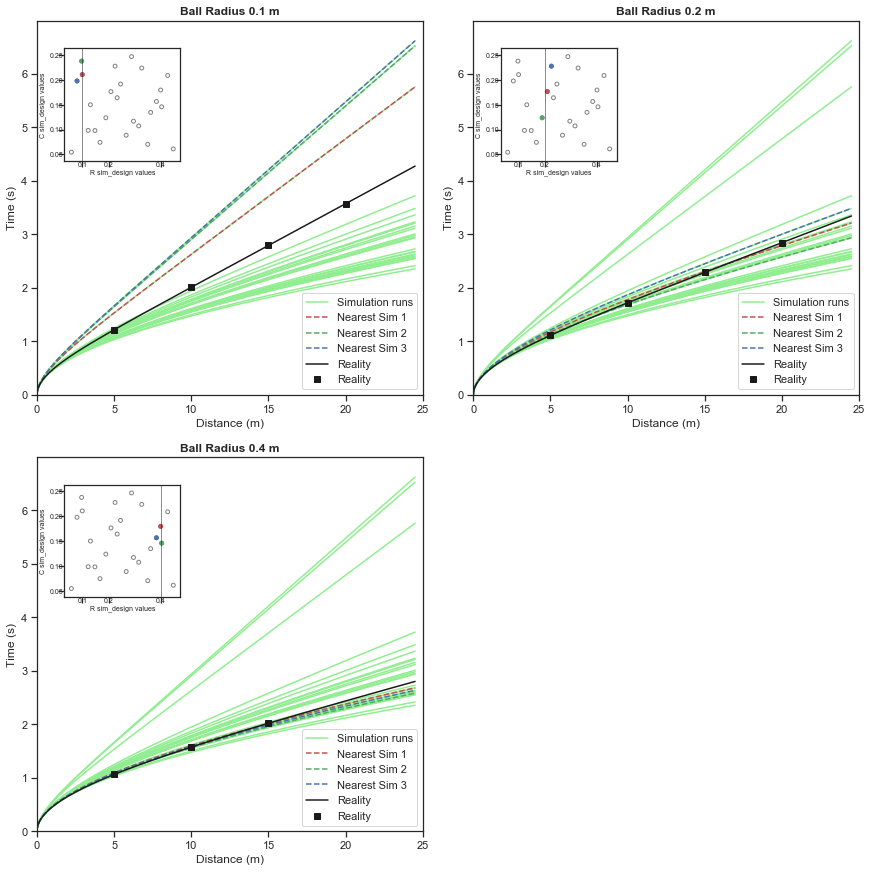

In [18]:
y_obs = list(data_dict['y_field'])
y_obs[-1] = y_obs[-1][0:3]
data_dict['y_field'] = y_obs
R = data_dict['R']             # radii of balls   .1,.2,.4 (m)
h_obs = [np.array([5.,10,15,20]),np.array([5.,10,15,20]),np.array([5.,10,15])]
data_dict['h_field'] = h_obs
plot_data(data_dict)

In [19]:
sim_design = data_dict['sim_design']

R_sim = sim_design[:,0]
C_sim = sim_design[:,1]
h_sim = data_dict['h_sim']
y_sim = data_dict['y_sim']

data = SepiaData(x_sim = np.reshape(R_sim,(len(R_sim),1)),
                 t_sim = np.reshape(C_sim,(len(C_sim),1)), 
                 y_sim = y_sim, y_ind_sim = h_sim,
                 x_obs = R.reshape((len(R),1)), y_obs = y_obs, y_ind_obs=h_obs)

In [20]:
data.transform_xt()
data.standardize_y()

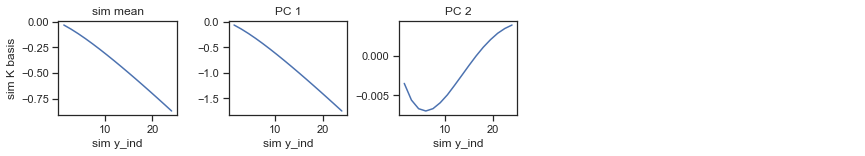

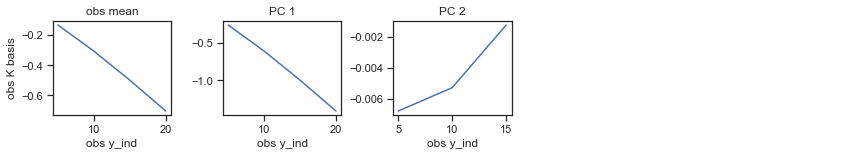

In [21]:
data.create_K_basis(2)
data.plot_K_basis()

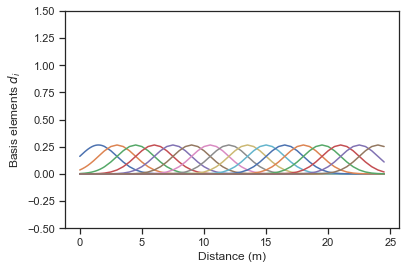

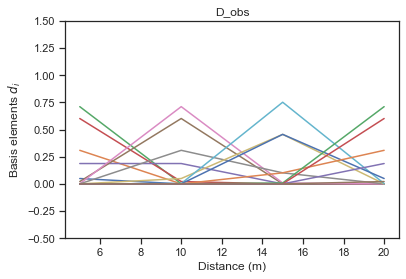

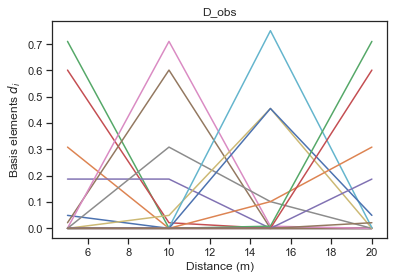

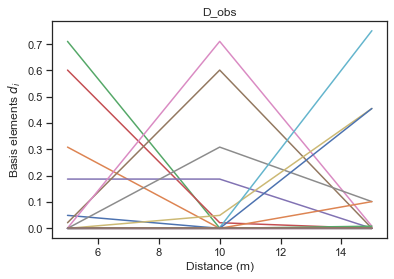

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 16, obs y dimension ragged
n  =     3 (number of observed data)
m  =    25 (number of simulated data)
p  =     1 (number of inputs)
q  =     1 (number of additional simulation inputs to calibrate)
pu =     2 (transformed response dimension)
pv =    16 (transformed discrepancy dimension)



In [22]:
# Generate D matrix with normal kernels
D_grid = h_sim # locations on which the kernels are centered
D_width = 1.5  # width of each kernel
pv = len(D_grid)
D_obs = []
D_sim = np.zeros(shape=(data.sim_data.y_ind.shape[0],pv))
h_dense = data_dict['h_dense']
D_dense = np.zeros(shape=(h_dense.shape[0],pv))
for i in range(len(h_obs)):
    tmp = np.zeros(shape=(data.obs_data.y_ind[i].shape[0],pv))
    for j in range(pv):
        tmp[:,j] = norm.pdf(h_obs[i], D_grid[j], D_width) # normal centered at D_grid[j] with sd D_width
    D_obs.append(tmp.T)
    
for j in range(pv):
    D_sim[:,j] = norm.pdf(h_sim, D_grid[j],D_width)
    D_dense[:,j] = norm.pdf(h_dense, D_grid[j],D_width)

data.create_D_basis(D_obs = D_obs, D_sim = D_sim)

plt.ylim(-.5,1.5)
plt.plot(h_dense,D_dense)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$")#;plt.title("D_dense (dense grid)")
plt.show()
plt.ylim(-.5,1.5)
plt.plot(h_obs[0],D_obs[0].T)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()
plt.plot(h_obs[1],D_obs[1].T)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()
plt.plot(h_obs[2],D_obs[2].T)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()

print(data)

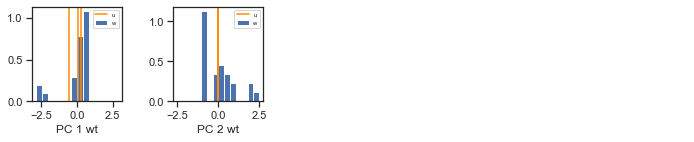

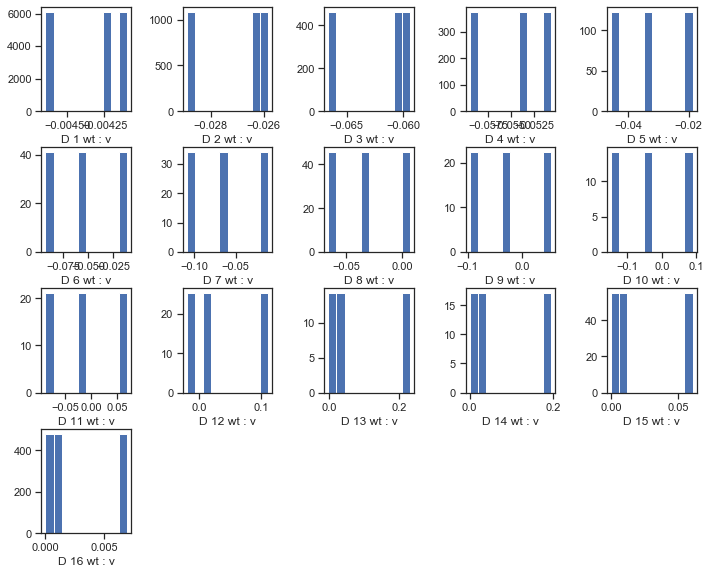

In [23]:
data.plot_K_weights()

Plotting up to 5 pairs. Change with parameter 'max_plots'


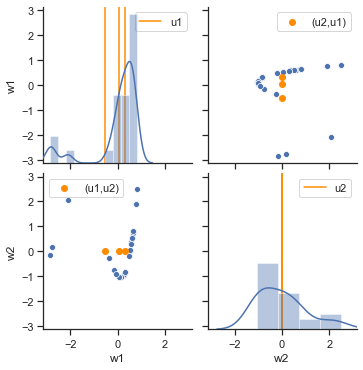

In [24]:
data.plot_u_w_pairs()

In [25]:
model = setup_model(data)

In [26]:
cachefile_name='ball_drop_1_ragged.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name):
   model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

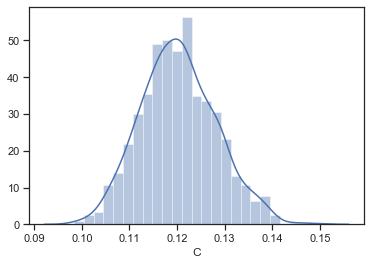

In [27]:
samples_dict = {p.name: p.mcmc_to_array(trim=1000,untransform_theta=True) for p in model.params.mcmcList}
theta_names = ['C']
SepiaPlot.theta_pairs(samples_dict,theta_names)

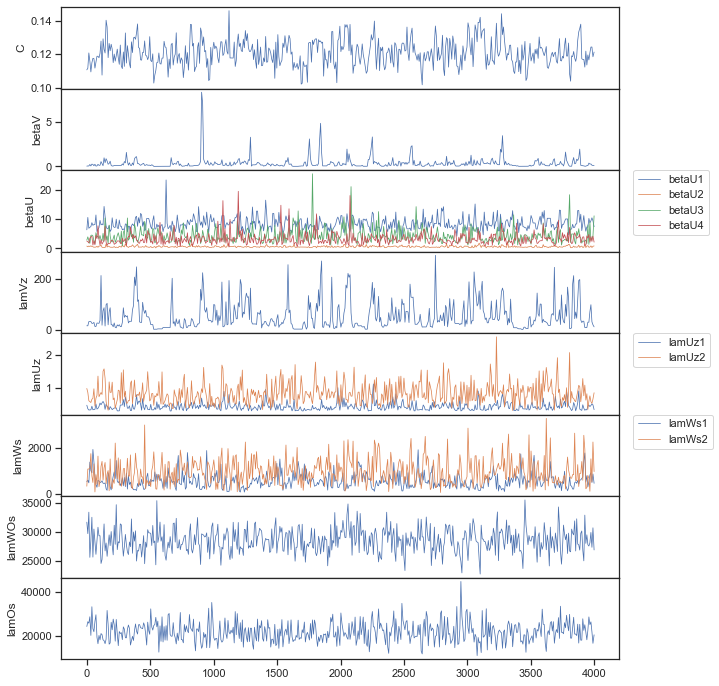

In [28]:
SepiaPlot.mcmc_trace(samples_dict,theta_names)